In [153]:
import time

import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 6.2.1 卷积运算

In [154]:
def corr2d(X, K):
    h, w = K.shape
    xh, xw = X.shape
    t_shape = np.array(X.shape)
    t_shape[-2], t_shape[-1] = t_shape[-2] + h - 1, t_shape[-1] + w - 1 
    T = torch.zeros(size=t_shape.tolist())
    # print((h-1)/2, -h/2, (w-1)/2, -w/2)
    T[int((h-1)/2):t_shape[-2]-int(h/2), int((w-1)/2):t_shape[-1]-int(w/2)] = X[:]
    R = torch.zeros_like(X)
    for i in range(h):
        for j in range(w):
            R[:] += T[i:i+xh, j:j+xw] * K[i, j]
    
    return R

def corr2d2(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()

    return Y

In [155]:
X = torch.arange(0, 10000).reshape(100, 100) * 1.0
K = torch.ones(size=[3, 3]) / 9
print(K)

tensor([[0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111]])


In [156]:
t = time.time()
R = corr2d(X, K)
print(time.time() - t)
# R

0.0019488334655761719


In [157]:
t = time.time()
R = corr2d2(X, K)
print(time.time() - t)
# R

0.07152462005615234


### 6.2.2 卷积层

In [158]:
class Conv2D(nn.Module):
    """
    卷积层
    """
    def __init__(self, kernel_size) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 6.2.3 图像中的目标边缘检测

> 如下是卷积层简单应用: 通过找到像素变化的位置, 来检测图像中不同颜色的边缘。首先, 我们构造一个6x8像素的黑白图像。 中间四列为黑色(0), 其余为白色(1)

In [159]:
X = torch.zeros((60, 80))
X[:, 5:9] = 1
X[:, 32:35] = 1
X[:, 50:54] = 1
X[25:30, 17:22] = 1

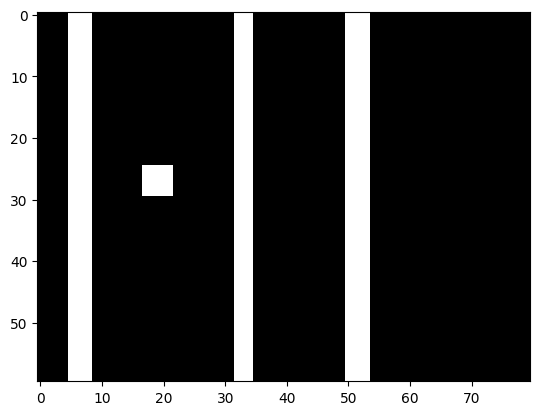

In [160]:
def imageshow(X):
    import matplotlib.pyplot as plt
    tensor_viz = np.array(X)
    plt.imshow(tensor_viz, cmap='gray')
    # plt.axis('off') # 隐藏坐标轴
    plt.show()
imageshow(X)  

> 接下来,构造一个高度为1、宽度为2的卷积核K。当进行卷积运算时, 如果水平相邻元素相同, 则输出为零, 否则输出非零 

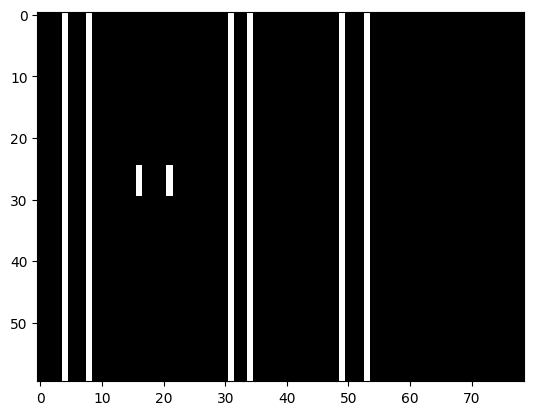

In [161]:
K = torch.Tensor([[1.0, -1.0]])
Y = corr2d2(X, K) ** 2 
imageshow(Y)

### 6.2.4 学习卷积核

> 如果我们只需寻找黑白边缘， 那么上面的边缘检测器足以。然而, 当有了更复杂数值的卷积核, 或者连续的卷积层时, 我们不可能手动设计滤波器。我们尝试看看是否可以通过仅仅查看输入-输出 来生成卷积核。

In [173]:
X = torch.ones((6, 8))
X[:,2:6] = 0
Y = corr2d2(X, torch.Tensor([[1.0, -1.0]]))

In [174]:
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

In [175]:
X = X.reshape((1, 1, *X.shape))
Y = Y.reshape(1, 1, *Y.shape)
lr = 0.01   # 学习率
X.shape

torch.Size([1, 1, 6, 8])

In [180]:
for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i+1) % 2 == 0:
        print(f"epoch {i+1}, loss {l.sum():.3f}")

epoch 2, loss 0.025
epoch 4, loss 0.015
epoch 6, loss 0.009
epoch 8, loss 0.005
epoch 10, loss 0.003


In [181]:
conv2d.weight.data

tensor([[[[ 0.9856, -0.9856]]]])

## 6.6 LeNet

In [188]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms

In [197]:
# 手写识别数字数据
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [190]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),    # 5 x 5 卷积层(6), 填充 2
    nn.AvgPool2d(kernel_size=2, stride=2),                      # 2 x 2 平均池化层, 步幅 2
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),              # 5 x 5 卷积层(16), 步幅 2 
    nn.AvgPool2d(kernel_size=2, stride=2),                      # 2 x 2 平均池化层, 步幅 2
    nn.Flatten(),                                               # 拉直
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),                   # 全连接层 120
    nn.Linear(120, 84), nn.Sigmoid(),                           # 全连接层 84
    nn.Linear(84, 10)                                           # 全连接层 10
)

In [191]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [202]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

In [224]:
sample_X, sample_Y = [], []
for i, (X, y) in enumerate(trainloader.dataset):
    if i > 10:
        break
    sample_X.append(X)
    sample_Y.append(y)

In [225]:
sample_Y

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3]

0